In [ ]:
# To be able to import from parent directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from utils import model_param_count, plot_images
from utils import IndexedDataset, RepresentationBuffer, MeanSquareDistancesStat

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T
from torchvision.models.feature_extraction import create_feature_extractor

import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
%matplotlib inline

In [2]:
train_dataset = datasets.CIFAR10(root = '../data', train = True,  transform = T.ToTensor(), download = True)
test_dataset  = datasets.CIFAR10(root = '../data', train = False, transform = T.ToTensor())

Files already downloaded and verified


In [26]:
msd = torch.load('../data/msd_hist_sup.pt').numpy()
msd_means = np.mean(msd, axis=0)
# Normalize
msd_means = (msd_means - min(msd_means))/(np.max(msd_means) - np.min(msd_means))

## Calculate known supervised metrics

In [86]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


accuracy,▁▁▁▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
loss,███▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.96708
loss,19.07789


In [110]:
class MyDataset(Dataset):
    """
    The only modification - returns not only X and Y, but also index
    To track the difficulty
    """
    def __init__(self, values, targets, transform):
        self.transform = transform
        self.values = values
        self.targets = targets

    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        return idx, self.transform(self.values[idx]), self.targets[idx]


def train_track(model, train_set, test_set, optim, loss, 
                n_epochs, device, feature_extractor=None, 
                msd_tracker=None, split="learn"):
    """
    Utility-function to train the model while logging all metrics
    Here it's incorrect to call the datasets train and test, 
    since at some point we switch them and track the forgetting metrics
    
    :model - trained NN model
    :train_set - first dataset, that is used to train the model
    :test_set - used for validation
    :optim - Optimizer already applied to the model
    :loss - Loss object
    :split - if "first" - we track the memorization for first set. Otherwize - track forgettig the second set
    :device - torch.device
    :feature_extractor - if not None - used to track MSD
    :msd_tracker - if not None - tracks Mean Squared Difference between epochs
    """
    run = wandb.init(project='Hard and Rare')
    model = model.to(device)
    train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
    test_loader  = DataLoader(test_set,  batch_size=256, shuffle=True)
    # Yes, I didn't find how to do it good enough
    if split == "learn":
        running_accuracy = np.zeros([len(train_set.targets), n_epochs])
        running_value = np.zeros([len(train_set.targets), n_epochs])
    else:
        running_accuracy = np.zeros([len(test_set.targets), n_epochs])
        running_value = np.zeros([len(test_set.targets), n_epochs])
    for ep in tqdm(range(n_epochs)):
        total_accuracy = 0
        total_loss = 0
        for vals, X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optim.zero_grad()
            out = model(X_batch)
            l = loss(out, y_batch)
            l.backward()
            optim.step()
            total_loss += l.item()
            if split == "forget":
                continue
            total_accuracy += torch.sum(torch.argmax(out, dim=1) == y_batch).item()
            for pos, vec, y in zip(vals.numpy(), out, y_batch):
                running_accuracy[int(pos.item()), ep] = (torch.argmax(vec)==y).item()
                running_value[int(pos.item()), ep] = vec[y].item()
            # If we need to track MSD - we extract features from middle layers
            if msd_tracker:
                for pos, z in zip(vals.numpy(), 
                                     feature_extractor(X_batch)["representation"]):
                    msd_tracker.push((pos, torch.flatten(z.cpu())[None, :]))
        if msd_tracker:
            msd_tracker.inc_epoch()
        run.log({"loss": total_loss,
                   "accuracy": total_accuracy / len(train_set)})
        if split == "learn":
            continue
        with torch.no_grad():
            for vals, X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                model.eval()
                out = model(X_batch)
                total_accuracy += torch.sum(torch.argmax(out, dim=1) == y_batch).item()
                for pos, vec, y in zip(vals.numpy(), out, y_batch):
                    running_accuracy[int(pos.item()), ep] = (torch.argmax(vec)==y).item()
                    running_value[int(pos.item()), ep] = vec[y].item()
            run.log({"accuracy": total_accuracy / len(train_set)})
    return running_accuracy, running_value


def calculate_metrics(model, train_dataset, test_dataset, optim, loss,
                      repr_layer_name, n_epochs=100, device=torch.device("cuda:0")):
    """
    This one is separate from other algorithms, because it takes two datasets
    :param model - your model to test
    :param train_dataset - first dataset, to train the model
    :param test_dataset - another dataset (still labeled!) to re-train the model
    
    :outputs: SSFT_metric, cartography, ChangeTimes
    :SSFT_metric - two arrays - remember time and forget time
    :cartography - array with predicted values for correct label on each epoch
    :ChangeTimes - array with the number of times that the correct label was changed to incorrect
    :MSD - array with MSD values tracked for the training on the first dataset
    """
    train_dataset = MyDataset(train_dataset.data, train_dataset.targets, train_dataset.transform)
    test_dataset = MyDataset(test_dataset.data, test_dataset.targets, test_dataset.transform)
    # For MSD tracking
    # Create feature extractor
    return_nodes = {
        repr_layer_name: "representation"
    }
    extractor = create_feature_extractor(model, return_nodes=return_nodes)
    # Create the tracker itself
    repr_buffer = RepresentationBuffer(len(train_dataset), 512)
    msd_tracker = MeanSquareDistancesStat(len(train_dataset), n_epochs, 512, repr_buffer)
    
    first_split, cartography = train_track(model, train_dataset, test_dataset, 
                                           optim, loss, n_epochs, device,
                                           extractor, msd_tracker,
                                           split="learn")
    # Firt Split Learn Time
    # Yes, I named it myself, since the paper doesn't
    fsrt = -np.ones(len(train_dataset.targets))
    # Number of changes of correct label from right to wrong
    changes = np.zeros(len(train_dataset.targets))
    for i in range(n_epochs-1, 1, -1):
        fsrt[(fsrt == -1) & (first_split[:, i]-first_split[:, i-1]==1)] = i
        changes[first_split[:, i]-first_split[:, i-1] == -1] += 1

    # Now we train on testset and track forgetting
    second_split, _ = train_track(model, test_dataset, train_dataset, optim, 
                                  loss, n_epochs, device, split="forget")
    # Second split remember time
    ssft = -np.ones(len(train_dataset.targets))
    for i in range(n_epochs-1, 1, -1):
        ssft[(ssft == -1) & (second_split[:, i]-second_split[:, i-1]==-1)] = i
        changes[second_split[:, i]-second_split[:, i-1] == -1] += 1

    return (fsrt, ssft), cartography, changes, msd_tracker.msd_hist

## Test the metric calculation function

In [112]:
import torchvision

backbone = torchvision.models.resnet18().to(device)
backbone.fc = nn.Linear(in_features=512, out_features=10).to(device)
optim = torch.optim.Adam(backbone.parameters(), lr=3e-4)
loss = nn.CrossEntropyLoss()

In [113]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform_clf = T.Compose([
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.Normalize(mean=MEAN, std=STD),
])

ds_train = datasets.CIFAR10(root='../data', transform=train_transform_clf, download=True)
ds_test = datasets.CIFAR10(root='../data', train=False, transform=train_transform_clf, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [114]:
optim = torch.optim.Adam(backbone.parameters(), lr=3e-4)
loss = nn.CrossEntropyLoss()

(fsrt, ssft), cartography, changes, msd = calculate_metrics(backbone, ds_train, ds_test, optim, loss, 
                                                            n_epochs=50, repr_layer_name="layer4.1.bn2")

accuracy,▁
loss,▁
accuracy,0.43756
loss,302.29588


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [49:43<00:00, 59.66s/it]


accuracy,▁▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
loss,█▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.96408
loss,20.16796


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [44:32<00:00, 53.46s/it]


In [135]:
# Seems as a fine solution
to_save = {"cartography": cartography,
           "fsrt": fsrt, 
           "ssft": ssft, 
           "changes": changes}

for name, item in to_save.items():
    np.save(f"../data/{name}.npy", item)

In [6]:
cartography = np.load("../data/cartography.npy")
fsrt = np.load("../data/fsrt.npy")
ssft = np.load("../data/ssft.npy")
changes = np.load("../data/changes.npy")

### Show MSD metrics

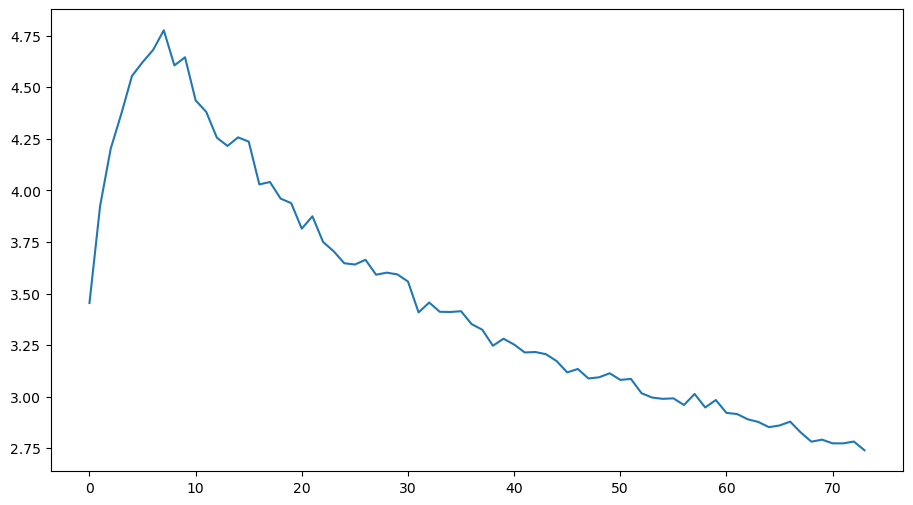

In [12]:
plt.figure(figsize=(11, 6))
msd_hist = np.array(msd[1:])
plt.plot(msd_hist.mean(axis=1))
plt.show()

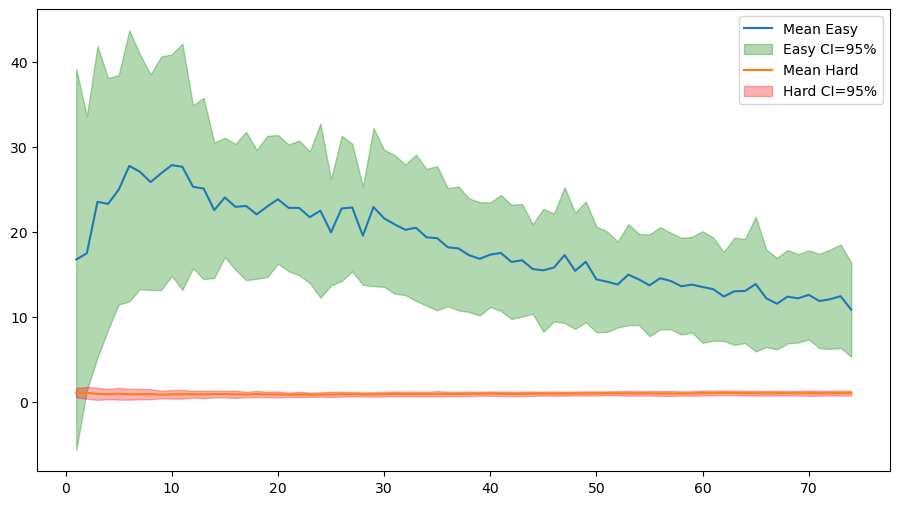

In [15]:
# Easy and hard by msd mean
M=100
easy_idx = np.argsort(msd_means)[-M:]
hard_idx = np.argsort(msd_means)[:M]

plt.figure(figsize=(11, 6))
msd_easy_hist = np.array(msd[1:, easy_idx])
easy_mean = np.mean(msd_easy_hist, axis=1)
easy_std = np.std(msd_easy_hist, axis=1)
plt.plot(list(range(1, msd.shape[0])), easy_mean, label='Mean Easy')
plt.fill_between(list(range(1, msd.shape[0])), easy_mean - 1.96*easy_std, easy_mean + 1.96*easy_std, color='green', alpha=0.3, label='Easy CI=95%')


msd_hard_hist = np.array(msd[1:, hard_idx])
hard_mean = np.mean(msd_hard_hist, axis=1)
hard_std = np.std(msd_hard_hist, axis=1)
plt.plot(list(range(1, msd.shape[0])), hard_mean, label='Mean Hard')
plt.fill_between(list(range(1, msd.shape[0])), hard_mean - 1.96*hard_std, hard_mean + 1.96*hard_std, color='red', alpha=0.3, label='Hard CI=95%')

plt.legend()
plt.fill
plt.show()

### Show cartography

In [16]:
cartography.shape

(50000, 50)

In [17]:
x = np.std(cartography, axis=1)
y = np.mean(cartography, axis=1)

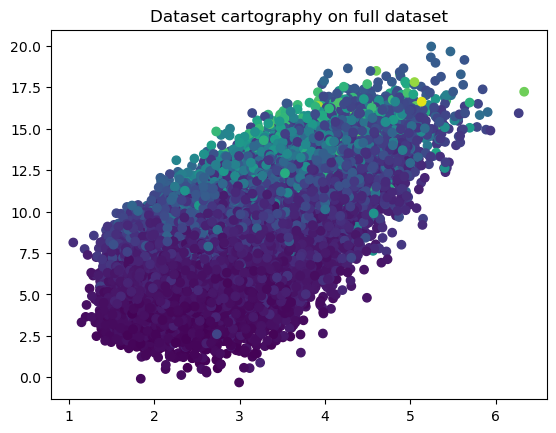

In [23]:
plt.title("Dataset cartography on full dataset")
plt.scatter(x, y, c=msd_means)
plt.show()

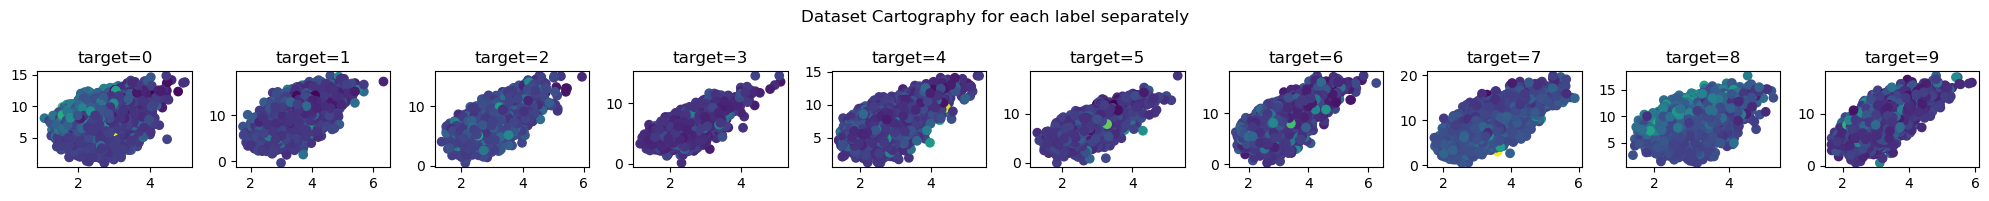

In [156]:
targ = train_dataset.targets
unique = np.unique(targ)
fig, ax = plt.subplots(1, len(unique), figsize=[2*len(unique), 2])
fig.suptitle("Dataset Cartography for each label separately")
for i in unique:
    ax[i].set_title(f"target={i}")
    # ax[i].set_xlim([0,1])
    # ax[i].set_ylim([0,1])
    ax[i].scatter(x[targ == i], y[targ == i], c=clusters[targ == i])
plt.tight_layout()
plt.show()

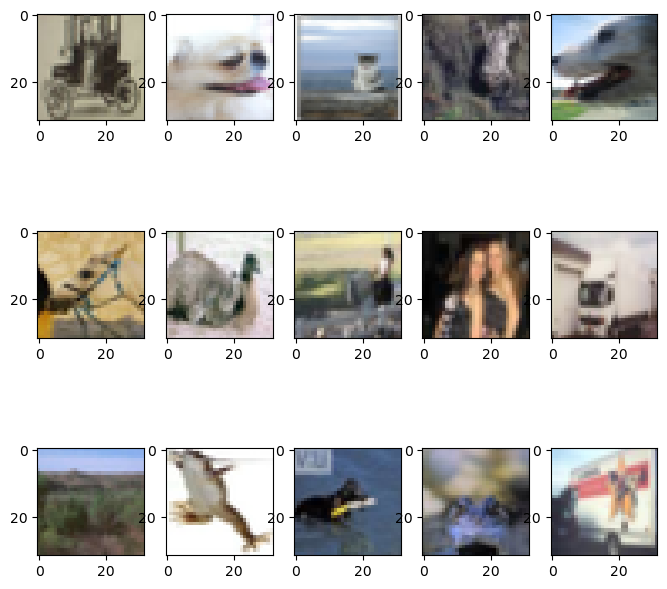

In [147]:
import numpy as np
import matplotlib.pyplot as plt

N=15
sorted_idx = np.argsort(y)
imgs = torch.cat([train_dataset[idx][0].reshape(1, 3, 32, 32) for idx in sorted_idx[:N]])

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    img = np.rollaxis(imgs[i-1].numpy(), 0, 3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

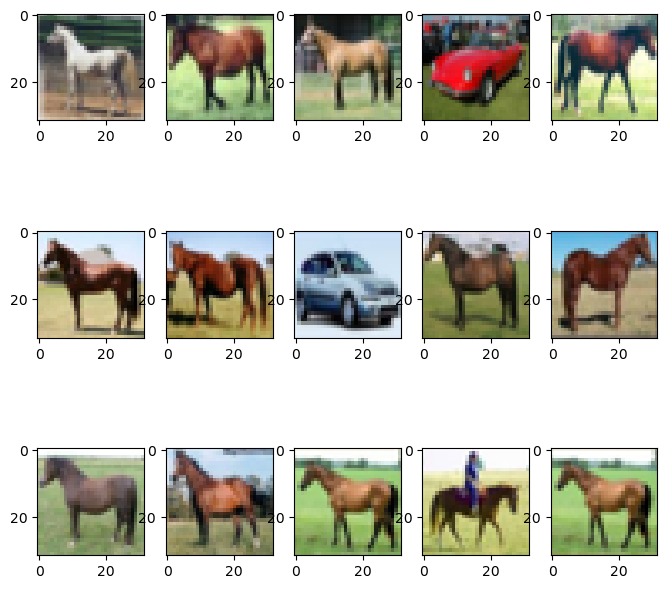

In [148]:
N=15
sorted_idx = np.argsort(y)
imgs = torch.cat([train_dataset[idx][0].reshape(1, 3, 32, 32) for idx in sorted_idx[-N:]])

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    img = np.rollaxis(imgs[i-1].numpy(), 0, 3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Show the SSFT metric

(array([2.9315e+04, 1.3620e+04, 3.8440e+03, 1.8870e+03, 8.0800e+02,
        3.3000e+02, 1.4200e+02, 4.1000e+01, 1.0000e+01, 3.0000e+00]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

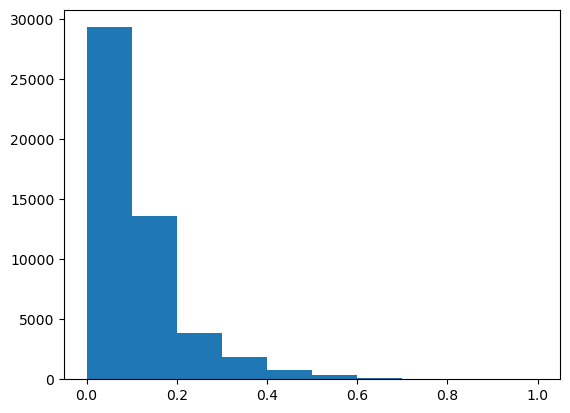

In [124]:
plt.hist(msd_means)

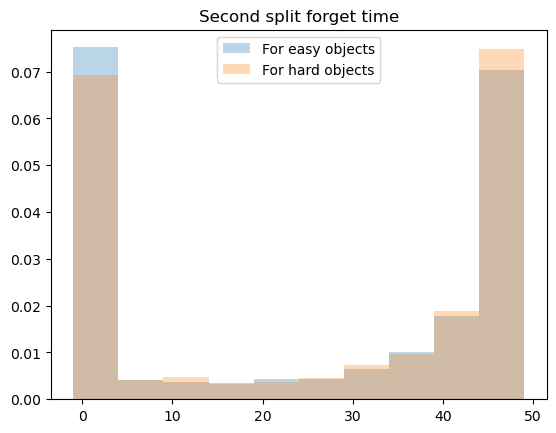

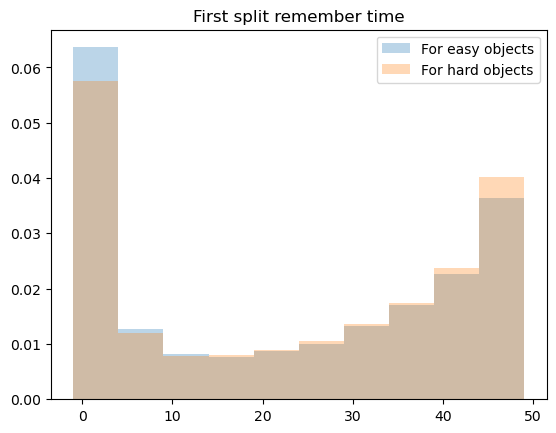

In [151]:
easy_idxs = msd_means <= 0.15

plt.title("Second split forget time")
plt.hist(ssft[easy_idxs], alpha=0.3, label="For easy objects", density=True)
plt.hist(ssft[~easy_idxs], alpha=0.3, label="For hard objects", density=True)
plt.legend()
plt.show()

plt.title("First split remember time")
plt.hist(fsrt[easy_idxs], alpha=0.3, label="For easy objects", density=True)
plt.hist(fsrt[~easy_idxs], alpha=0.3, label="For hard objects", density=True)
plt.legend()
plt.show()

## Sergey's paper metric
I probably should have asked which paper...

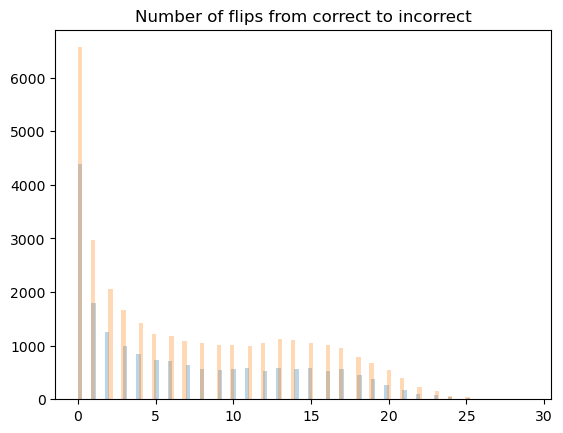

In [150]:
plt.title("Number of flips from correct to incorrect")
plt.hist(changes, bins=100)
plt.show()

## Metrics of correlation

In [1]:
import pandas as pd
from scipy.stats import pearsonr

def calculate_correlation(array, cartography, ssft, changes):
    result = {}
    x = np.std(cartography, axis=1)
    y = np.mean(cartography, axis=1)
    result["cartography"] = pearsonr(array, x**2 + y**2)
    result["Second-Split forget time"] = pearsonr(array, ssft)
    result["Number of label changes"] = pearsonr(array, changes)
    return result

In [4]:
cartography = np.load("../data/cartography.npy")
fsrt = np.load("../data/fsrt.npy")
ssft = np.load("../data/ssft.npy")
changes = np.load("../data/changes.npy")

In [9]:
correlations = {}

In [10]:
msd = torch.load('../data/msd_hist_sup.pt').numpy()
msd_means = np.mean(msd, axis=0)
# Normalize
msd_means = (msd_means - min(msd_means))/(np.max(msd_means) - np.min(msd_means))
correlations["Supervised MSD"] = calculate_correlation(msd_means, cartography, ssft, changes)

msd = torch.load('msd_hist.pt').numpy()
msd_means = np.mean(msd, axis=0)
# Normalize
msd_means = (msd_means - min(msd_means))/(np.max(msd_means) - np.min(msd_means))
correlations["Unsupervised MSD_mean"] = calculate_correlation(msd_means, cartography, ssft, changes)

In [11]:
df = pd.read_csv("../data/msd_statistics.csv", index_col=0)
correlations["Unsupervised MSD_std"] = calculate_correlation(df["msd_std"].values, cartography, ssft, changes)
correlations["Discrepacy score"] = calculate_correlation(df["disr_score"].values, cartography, ssft, changes)
correlations["Clusters based on MSD"] = calculate_correlation(df["cluster"].values, cartography, ssft, changes)

In [14]:
for our_name, theirs in correlations.items():
    for their_name, their_metric in theirs.items():
        print(f"Correlation between {our_name} and {their_name}: {their_metric.statistic:.3f}")

Correlation between Supervised MSD and cartography: 0.705
Correlation between Supervised MSD and Second-Split forget time: -0.356
Correlation between Supervised MSD and Number of label changes: -0.369
Correlation between Unsupervised MSD_mean and cartography: 0.285
Correlation between Unsupervised MSD_mean and Second-Split forget time: -0.214
Correlation between Unsupervised MSD_mean and Number of label changes: -0.214
Correlation between Unsupervised MSD_std and cartography: 0.191
Correlation between Unsupervised MSD_std and Second-Split forget time: -0.147
Correlation between Unsupervised MSD_std and Number of label changes: -0.148
Correlation between Discrepacy score and cartography: -0.010
Correlation between Discrepacy score and Second-Split forget time: -0.012
Correlation between Discrepacy score and Number of label changes: -0.008
Correlation between Clusters based on MSD and cartography: -0.061
Correlation between Clusters based on MSD and Second-Split forget time: 0.029
Correl